In [15]:
# Utility 
from typing import List

# Data manipulation
import pandas as pd
import numpy as np

# Scientific
from scipy.sparse import hstack
from scipy.sparse import csr_matrix

# Machine learning
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

We begin by reading data from `bodies.csv` and `stances.csv`.

In [16]:
bodies = pd.read_csv("../data/bodies.csv", )
stances = pd.read_csv("../data/stances.csv")

In [17]:
bodies

,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...
...,...,...
1678,2528,Intelligence agencies hunting for identity of ...
1679,2529,"While Daleks ""know no fear"" and ""must not fear..."
1680,2530,More than 200 schoolgirls were kidnapped in Ap...
1681,2531,A Guantanamo Bay prisoner released last year a...


In [18]:
stances.head

<bound method NDFrame.head of                                                 Headline  Body ID     Stance
0      Police find mass graves with at least '15 bodi...      712  unrelated
1      Hundreds of Palestinians flee floods in Gaza a...      158      agree
2      Christian Bale passes on role of Steve Jobs, a...      137  unrelated
3      HBO and Apple in Talks for $15/Month Apple TV ...     1034  unrelated
4      Spider burrowed through tourist's stomach and ...     1923   disagree
...                                                  ...      ...        ...
49967  Urgent: The Leader of ISIL 'Abu Bakr al-Baghda...     1681  unrelated
49968  Brian Williams slams social media for speculat...     2419  unrelated
49969  Mexico Says Missing Students Not Found In Firs...     1156      agree
49970  US Lawmaker: Ten ISIS Fighters Have Been Appre...     1012    discuss
49971  Shots Heard In Alleged Brown Shooting Recordin...     2044  unrelated

[49972 rows x 3 columns]>

Our dataset consists of __1683__ unique article bodies and __49972__ matching headlines.  
We can see that both DataFrames share __Body ID__ column which will be necessary for combining those tables into one DataFrame.  
We are renaming columns for consistency.

In [19]:
bodies = bodies.rename(columns={"Body ID": "body_id", "articleBody": "article_body"})
stances = stances.rename(columns={"Body ID": "body_id"})
stances.columns = stances.columns.str.lower()

In [20]:
bodies.columns.values

array(['body_id', 'article_body'], dtype=object)

In [21]:
stances.columns.values

array(['headline', 'body_id', 'stance'], dtype=object)

In [22]:
stances_uniqe_body_ids = np.unique(stances.body_id.values)

We are making sure that number of unique __body_ids__ match between both frames.

In [23]:
print("Matching body_ids?")
sorted(bodies.body_id.values) == sorted(stances_uniqe_body_ids)

Matching body_ids?


True

Dataset consists of 4 stances across all headlines:
- agree: headline and body are related and agree (e.g. positive headline and positive body)
- disagree: headline and body are related and disagree (e.g. positive headline and negative body)
- discuss: headline and body are related but neither agree or disagree (e.g. question in headline)
- unrelated: headline and body are not related

In [24]:
print(f"Unique stances: {np.unique(stances.stance)}")

Unique stances: ['agree' 'disagree' 'discuss' 'unrelated']


We join both DataFrames on __body_id__ column.

In [25]:
df = pd.merge(bodies, stances, on="body_id")

As we can see our final dataset consists of mostly unrelated headline-body combinations.  
This means that dataset is __imbalanced__.  

It's important to note that each unique body has several combinations.

In [26]:
print("Class split in the dataset")
df['stance'].value_counts()

Class split in the dataset


unrelated    36545
discuss       8909
agree         3678
disagree       840
Name: stance, dtype: int64

In [27]:
print("Class split in the dataset (% of all labels)")
df['stance'].value_counts(normalize=True) * 100

Class split in the dataset (% of all labels)


unrelated    73.130953
discuss      17.827984
agree         7.360122
disagree      1.680941
Name: stance, dtype: float64

In [28]:
df

,body_id,article_body,headline,stance
0,0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",unrelated
1,0,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...,unrelated
2,0,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,unrelated
3,0,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,unrelated
4,0,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,unrelated
...,...,...,...,...
49967,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets tipped more than $2,00...",agree
49968,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets $2,000 tip",agree
49969,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Luckiest Pizza Delivery Guy Ever Gets $2,000 Tip",agree
49970,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...",Ann Arbor pizza delivery driver surprised with...,agree


For the purpose of this project we need to consider two stages of classification:
1. Relation classifiaction
2. Stance classification

All combinations are first classified by __relation classifier__. If headline and body are __unrelated__ they are not further analyzed. In case combination is classified as __related__ it is fed into __stance classifier__ that returns type of relation between headline and body.

In this step we create additional column that contains information about relation status of those features.

In [29]:
mappings = { key: "related" for key in ["agree", "disagree", "discuss"]}
mappings.update({"unrelated": "unrelated"})
df["relation"] = df.apply(lambda row: mappings[row["stance"]], axis=1)
df

,body_id,article_body,headline,stance,relation
0,0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",unrelated,unrelated
1,0,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...,unrelated,unrelated
2,0,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,unrelated,unrelated
3,0,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,unrelated,unrelated
4,0,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,unrelated,unrelated
...,...,...,...,...,...
49967,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets tipped more than $2,00...",agree,related
49968,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets $2,000 tip",agree,related
49969,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Luckiest Pizza Delivery Guy Ever Gets $2,000 Tip",agree,related
49970,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...",Ann Arbor pizza delivery driver surprised with...,agree,related


Headline-body combinations that are related make up only about 27% of the whole dataset.
In this project we will focus on utilzing dataset as it is, which means we won't utilize any __resampling strategies__.

In [30]:
print("Class split for relation analysis")
df['relation'].value_counts()

Class split for relation analysis


unrelated    36545
related      13427
Name: relation, dtype: int64

In [31]:
print("Class split for relation analysis (% of all labels)")
df['relation'].value_counts(normalize=True) * 100

Class split for relation analysis (% of all labels)


unrelated    73.130953
related      26.869047
Name: relation, dtype: float64

In [32]:
example_unrelated = df[df["relation"] == "unrelated"].first_valid_index()
example_related = df[df["relation"] == "related"].first_valid_index()

In [33]:
def formatted_print(df, idx):
    data = df.iloc[idx]
    print(f"Headline-Body relation: {data.relation.capitalize()}")
    print("---")
    print(data.headline)
    print("---")
    print(data.article_body)

In [34]:
formatted_print(df, example_unrelated)

Headline-Body relation: Unrelated
---
Soldier shot, Parliament locked down after gunfire erupts at war memorial
---
A small meteorite crashed into a wooded area in Nicaragua's capital of Managua overnight, the government said Sunday. Residents reported hearing a mysterious boom that left a 16-foot deep crater near the city's airport, the Associated Press reports. 

Government spokeswoman Rosario Murillo said a committee formed by the government to study the event determined it was a "relatively small" meteorite that "appears to have come off an asteroid that was passing close to Earth." House-sized asteroid 2014 RC, which measured 60 feet in diameter, skimmed the Earth this weekend, ABC News reports. 
Murillo said Nicaragua will ask international experts to help local scientists in understanding what happened.

The crater left by the meteorite had a radius of 39 feet and a depth of 16 feet,  said Humberto Saballos, a volcanologist with the Nicaraguan Institute of Territorial Studies wh

In [35]:
formatted_print(df, example_related)

Headline-Body relation: Related
---
Small Meteorite Strikes in Nicaragua's Capital City of Managua
---
A small meteorite crashed into a wooded area in Nicaragua's capital of Managua overnight, the government said Sunday. Residents reported hearing a mysterious boom that left a 16-foot deep crater near the city's airport, the Associated Press reports. 

Government spokeswoman Rosario Murillo said a committee formed by the government to study the event determined it was a "relatively small" meteorite that "appears to have come off an asteroid that was passing close to Earth." House-sized asteroid 2014 RC, which measured 60 feet in diameter, skimmed the Earth this weekend, ABC News reports. 
Murillo said Nicaragua will ask international experts to help local scientists in understanding what happened.

The crater left by the meteorite had a radius of 39 feet and a depth of 16 feet,  said Humberto Saballos, a volcanologist with the Nicaraguan Institute of Territorial Studies who was on the 

We drop "body_id" column as it's no longer needed.

In [36]:
df = df.drop(columns="body_id")
df

,article_body,headline,stance,relation
0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",unrelated,unrelated
1,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...,unrelated,unrelated
2,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,unrelated,unrelated
3,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,unrelated,unrelated
4,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,unrelated,unrelated
...,...,...,...,...
49967,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets tipped more than $2,00...",agree,related
49968,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets $2,000 tip",agree,related
49969,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Luckiest Pizza Delivery Guy Ever Gets $2,000 Tip",agree,related
49970,"ANN ARBOR, Mich. – A pizza delivery man in Mic...",Ann Arbor pizza delivery driver surprised with...,agree,related


We split dataset into sets of __features X__ and __labels y__.

Given nature of the project, we need to use two separate sets of labels for two stages of classification.

In [37]:
X, y = df[["article_body", "headline"]], df[["stance", "relation"]]
X

,article_body,headline
0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun..."
1,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...
2,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...
3,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa
4,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...
...,...,...
49967,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets tipped more than $2,00..."
49968,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets $2,000 tip"
49969,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Luckiest Pizza Delivery Guy Ever Gets $2,000 Tip"
49970,"ANN ARBOR, Mich. – A pizza delivery man in Mic...",Ann Arbor pizza delivery driver surprised with...


In [38]:
y

,stance,relation
0,unrelated,unrelated
1,unrelated,unrelated
2,unrelated,unrelated
3,unrelated,unrelated
4,unrelated,unrelated
...,...,...
49967,agree,related
49968,agree,related
49969,agree,related
49970,agree,related


We start processing our data by splitting dataset into two subsets:
- Train: used during training of our models
- Test: used for measuring performance of trained models

We use 80:20 split which means 20% of the original dataset will be used for testing purposes only.  
To make sure repeated experiments will yield consistent results we set constant "random_state" value.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [40]:
y_train.shape, y_test.shape

((39977, 2), (9995, 2))

In [41]:
y_train

,stance,relation
13462,unrelated,unrelated
22169,unrelated,unrelated
9426,unrelated,unrelated
17403,unrelated,unrelated
13912,unrelated,unrelated
...,...,...
21243,unrelated,unrelated
45891,discuss,related
42613,discuss,related
43567,discuss,related


In this part we prepare two separate sets of labels for training and testing both __relation classifier__ and __stance classifier__.  
Former requires labels based on "relation" column that, which have to be changed into binary format where related is represented by 1 and unrelated by 0.  
Latter first requires dropping all rows that contain unrelated combinations and "relation" as it is not needed in second step of classification process. We drop unrelated combinations because we assume that for training and testing purpose we want to only interact with __correctly__ classified samples from first stage.  
Finally we transform our labels into number form. We end up with three pairs of values:
- agree -> 0
- disagree -> 1
- discuss -> 2

In this step we need to extract indices of rows that contain related samples, as they will be necessary for __stance classifier__ testing as we will need to test only on samples that were correctly predicted by __relation classifier__.

In [42]:
# Prepare labels for relation classifier training and testing 
y_train_rel = np.array(y_train["relation"])
y_train_rel = np.where(y_train_rel == "related", 1, 0)

y_test_rel = np.array(y_test["relation"])
y_test_rel = np.where(y_test_rel == "related", 1, 0)


# Find all rows that are contain related headline-body combinations
y_train_cls = y_train["stance"] != "unrelated"
y_test_cls = y_test["stance"] != "unrelated"

# Extract index numbers for related headline-body combinations
y_train_cls_indices = y_train_cls[y_train_cls].index
y_test_cls_indices = y_test_cls[y_test_cls].index

# Prepare labels for stance classifier training and testing
y_train_cls = np.array(y_train.loc[y_train_cls].drop(columns=["relation"])).ravel()
y_test_cls = np.array(y_test.loc[y_test_cls].drop(columns=["relation"])).ravel()

# Perform encoding on stance classification labels
label_encoder = LabelEncoder()
y_train_cls = label_encoder.fit_transform(y_train_cls)
y_test_cls = label_encoder.fit_transform(y_test_cls)
cls_labels = label_encoder.classes_
cls_labels

array(['agree', 'disagree', 'discuss'], dtype=object)

In [43]:
# Create stance classification train and test subsets
X_train_cls = X_train.loc[y_train_cls_indices]
X_test_cls = X_test.loc[y_test_cls_indices]

Last step in data preparation process will consist of several operations.  
We will vectorize and process both __features__ (headline and article_body) separetly. 
For this project we use TF-IDF vectorizer that will remove stop words, split all words and turn them into lower case. Vectorizer will yield number of features matching number of unique words and each feature will contain TF-IDF value for that particular word, that is calculated based on how frequently word appears in dataset and number of documents in dataset.  
Both headline and body vectorizers are fit only __once__ with full training dataset, and later only used to transform other subsets into the same representation. This way we avoid _leakage_ between train and test datsets. It's important to note that we need to save both vectorizers and with our model if we want to use our model in the future.  
It's important to mention that we need to concatenate features extracted with both vectorizers into a single matrix, so that both are utilized in training.

Other more sophisticated ways of feature extraction can be used to further increase performance of models.

In [44]:
class TFIDFTransform:
    def __init__(self, headline_vectorizer, body_vectorizer):
        self._headline_vectorizer = headline_vectorizer
        self._body_vectorizer = body_vectorizer


    def fit_transform(self, df):
        headline, body = df["headline"], df["article_body"]

        X_headline = self._headline_vectorizer.fit_transform(headline)
        X_body = self._body_vectorizer.fit_transform(body)

        X = hstack((X_headline, X_body))
        return X

    def transform(self, df):
        headline, body = df["headline"], df["article_body"]

        X_headline = self._headline_vectorizer.transform(headline)
        X_body = self._body_vectorizer.transform(body)

        X = hstack((X_headline, X_body))
        return X

In [45]:
headline_vectorizer = TfidfVectorizer(analyzer="word", stop_words="english", lowercase=True, token_pattern=r"\w+")
body_vectorizer = TfidfVectorizer(analyzer="word", stop_words="english", lowercase=True, token_pattern=r"\w+")

tfidf_transform = TFIDFTransform(headline_vectorizer=headline_vectorizer, body_vectorizer=body_vectorizer)

In [46]:
X_train_rel_vec = tfidf_transform.fit_transform(X_train)
X_train_cls_vec = tfidf_transform.transform(X_train_cls)
X_test_rel_vec = tfidf_transform.transform(X_test)
X_test_cls_vec = tfidf_transform.transform(X_test_cls)

After vectorization we end up with 25950 features that will be used in classification.

In [47]:
X_train_rel_vec.shape

(39977, 26001)

In [48]:
X_test_rel_vec.shape

(9995, 26001)

In this short example we will utilize XGBoost algorithm thus we transform our data into relevant format.

In [49]:
D_train_rel = xgb.DMatrix(X_train_rel_vec, label=y_train_rel)
D_test_rel = xgb.DMatrix(X_test_rel_vec, label=y_test_rel)

D_train_cls = xgb.DMatrix(X_train_cls_vec, label=y_train_cls)
D_test_cls = xgb.DMatrix(X_test_cls_vec, label=y_test_cls)

In [50]:
y_train_cls.shape

(10660,)

In [51]:
y_train_rel.shape

(39977,)

In [52]:
def print_metrics(y_true: np.ndarray | List[int], y_pred: np.ndarray | List[int], average: str="binary") -> None:
    print("Precision = {}".format(precision_score(y_true, y_pred, average=average)))
    print("Recall = {}".format(recall_score(y_true, y_pred, average=average)))
    print("Accuracy = {}".format(accuracy_score(y_true, y_pred)))
    print("Balanced accuracy = {}".format(balanced_accuracy_score(y_true, y_pred)))

def plot_cm(y_true: np.ndarray | List[int], y_pred: np.ndarray | List[int], labels: List[str]) -> None:
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    disp.plot()

In [53]:
# Booster hyper-parameters
param = {
    'eta': 0.3, 
    'max_depth': 12
    } 

steps = 100  # The number of training iterations

In [54]:
rel_classifier = xgb.train(param, D_train_rel, steps)

As we can see basic model is correct in predicting which headline-body combinations are related in 90% of cases!  
At this stage it's important to note that we are currently using __hold out__ strategy that might not show real performance of the model, because we can only see how well model works on __one specific subset__ of our whole dataset. To further investige performance we could use create training loop with different __seed__ values that we would use during train-test split, and average performance of our model across k different runs.  
Another option would be to employ k-fold Cross-Valdiation strategy.  
But even then internal model structure might vary because of probabilistic nature of machine learning.

In [55]:
rel_pred = rel_classifier.predict(D_test_rel)
rel_pred = np.where(rel_pred < 0.5, 0, 1)

print_metrics(y_test_rel, rel_pred)

Precision = 0.9870283018867925
Recall = 0.9074810263823636
Accuracy = 0.9710855427713857
Balanced accuracy = 0.951457724037889


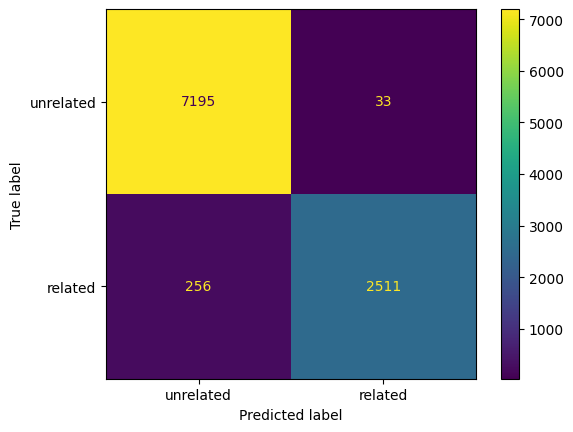

In [56]:
plot_cm(y_test_rel, rel_pred, labels=["unrelated", "related"])

In [57]:
param_cls = {
    'eta': 0.3, 
    'max_depth': 20,
    'num_class': 3
    } 

steps = 100  # The number of training iterations

In [58]:
cls_classifier = xgb.train(param_cls, D_train_cls, steps)

Stance classifier achieves about 85% of balanced accuracy (that considers how much imbalance there is between classes).

In [59]:
cls_pred = cls_classifier.predict(D_test_cls)
print_metrics(y_test_cls, cls_pred, average="macro")

Precision = 0.8696302465319109
Recall = 0.8463269241128498
Accuracy = 0.9400072280448138
Balanced accuracy = 0.8463269241128498


We can see that classifiers struggles the most with "disagree" stance which is least common in the dataset. We could try to find better combination of hyper-parameters to further increase quality of our model or consider experimenting with __resampling__ our dataset to lower class imbalance.

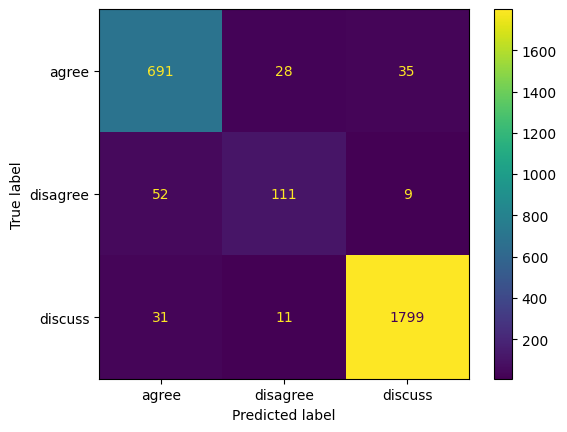

In [60]:
plot_cm(y_test_cls, cls_pred, labels=cls_labels)

In final step we build simple, global pipeline that will utilize our two models for predictions.  

In [61]:
# Find array indices of correctly predicted labels that are also related from relation classifier
def find_correct_related_predictions(y_test: List[int] | np.ndarray, y_pred: List[int] | np.ndarray) -> List[int]:
    matching_indices = []
    for i in range(len(y_pred)):
        if (y_pred[i] == y_test[i]) and y_pred[i] == 1:
            matching_indices.append(i)
    
    return matching_indices

# Find row indices (DataFrame) of correctly predicted labels in pre-transformation label set
def find_cls_matching_indices(y_test: pd.DataFrame, y_test_indices: List[int], matching_indices: List[int]):
    X_indices = y_test.iloc[matching_indices].index

    y_indices = []
    for idx in X_indices:
        y_indices.append(y_test_indices.index(idx))

    return X_indices, y_indices

In [62]:
#Test prediction pipeline
def predict():
    # Classify if related 
    rel_pred = rel_classifier.predict(D_test_rel)
    rel_pred = np.where(rel_pred < 0.5, 0, 1)

    # Find subset of test stance classication set that contains only samples that were predicted
    # correctly in the previous step (in this case about 10% of total stance test set is lost)
    matching_indices = find_correct_related_predictions(y_test_rel, rel_pred)
    X_test_indices, y_test_indices = find_cls_matching_indices(y_test, list(y_test_cls_indices), matching_indices)
    
    # Prepare data for prediction
    X_test_cls_vec = tfidf_transform.transform(X_test_cls.loc[X_test_indices])
    D_test_cls = xgb.DMatrix(X_test_cls_vec, label=y_test_cls[y_test_indices])

    # Classify stance
    cls_pred = cls_classifier.predict(D_test_cls)
    print_metrics(y_test_cls[y_test_indices], cls_pred, average="macro")
    plot_cm(y_test_cls[y_test_indices], cls_pred, labels=cls_labels)

We finish with classification system that can correctly classify stance of about 86-88% (if our future data has roughly the same distribution) of related headline-body combinations.

Precision = 0.8810485299578082
Recall = 0.8567509172658055
Accuracy = 0.9442453205894066
Balanced accuracy = 0.8567509172658055


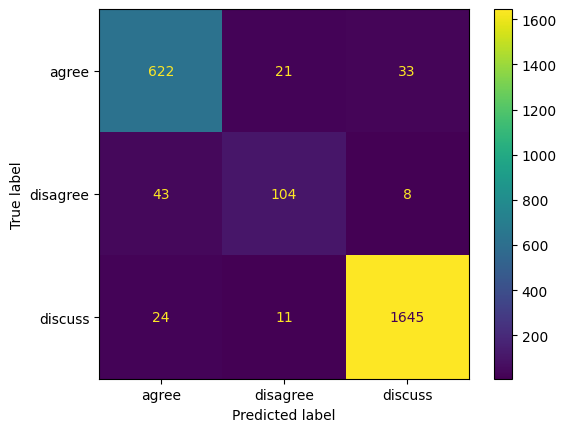

In [63]:
predict()

That concludes this simple experiment. In the future we can further investigate things: dataset resampling, model optimization (through hyper-parameters), using/combining different model architectures like Transformers (+ XGBoost).